In [577]:
%pylab inline
import pandas as pd

rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

Populating the interactive namespace from numpy and matplotlib


In [578]:
import theano
theano.config.floatX = 'float64'

import theano.tensor as tt
from theano.tensor.nlinalg import det

import pymc3 as pm

In [579]:
cluster = np.random.binomial(1, 0.33, (1000, 1))
batch = np.random.binomial(1, 0.5, (1000, 1))
depth = np.random.uniform(size=(1000, 1))
noise = np.random.normal(size=(1000, 1))

df = pd.DataFrame(data={'cluster': cluster[:, 0],
                        'batch': batch[:, 0],
                        'depth': depth[:, 0],
                        'noise': noise[:, 0]},
                  index=np.arange(cluster.shape[0]))

In [580]:
df['y'] = df['cluster'] + df['batch'] * 0.5 + df['depth'] * 2 + df['noise'] * 0.25

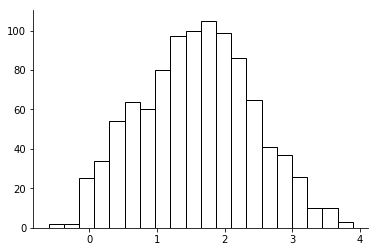

In [581]:
df['y'].hist(bins=20, grid=False, ec='k', fc='w');

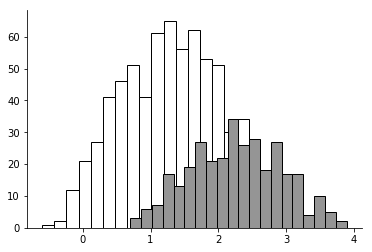

In [602]:
for v, g in df.groupby('cluster'):
    g['y'].hist(bins=20, grid=False, ec='k', fc=cm.Greys(v / 2));

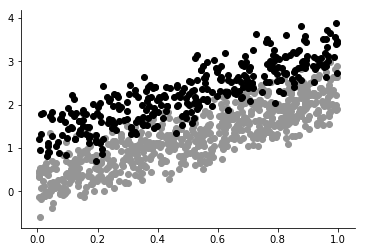

In [601]:
for c, gc in df.groupby('cluster'):
    plt.scatter(gc['depth'], gc['y'], c=cm.Greys(c / 2 + 1 / 2));

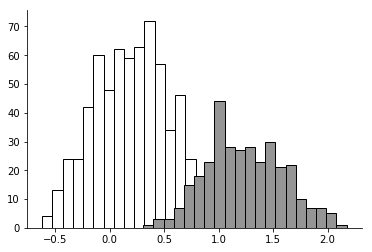

In [603]:
for v, g in df.groupby('cluster'):
    (g['y'] - g['depth'] * 2).hist(bins=20, grid=False, ec='k', fc=cm.Greys(v / 2));

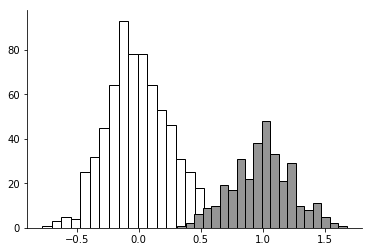

In [604]:
for v, g in df.groupby('cluster'):
    (g['y'] - g['batch'] * 0.5 - g['depth'] * 2).hist(bins=20, grid=False, ec='k',fc=cm.Greys(v / 2));

\\[
y \vert (z_i = k) \sim \mathcal{N}(\mu_{k}, \sigma_k)
\\]

In [637]:
K = 2
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1., shape=(K,))
    mu_cluster = pm.Normal('mu_cluster', mu=0., sd=1., testval=1., shape=(1, K))
    pi = pm.Dirichlet('pi', a=0.1 * np.ones(K), shape=(K,))
    
    likelihood = pm.NormalMixture('y', w=pi, mu=mu_cluster, sd=sigma, observed=df['y'])

In [638]:
means, sds, elbos = pm.variational.advi(model=model, n=1000, learning_rate=1e-1)

Average ELBO = -2,490.2: 100%|███████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2535.60it/s]
Finished [100%]: Average ELBO = -2,489.5


In [639]:
means

{'mu_cluster': array([[ 0.96668414,  1.57696357]]),
 'pi_stickbreaking_': array([-5.4162677]),
 'sigma_log_': array([-0.42210571, -0.20109472])}

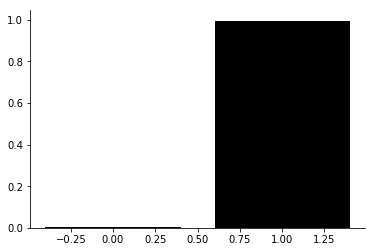

In [652]:
weights = pm.distributions.transforms.stick_breaking.backward(means['pi_stickbreaking_']).eval()
plt.bar(np.arange(K), weights, color='k');

In [590]:
from scipy import stats

In [641]:
RV = stats.norm(loc=means['mu_cluster'], scale=exp(means['sigma_log_']))

In [642]:
inferred_cluster = df['y'].apply(RV.logpdf).apply(np.argmax)
df['inferred_cluster'] = inferred_cluster

In [643]:
pd.crosstab(df['cluster'], df['inferred_cluster'])

inferred_cluster,0,1
cluster,,
0,381,296
1,37,286


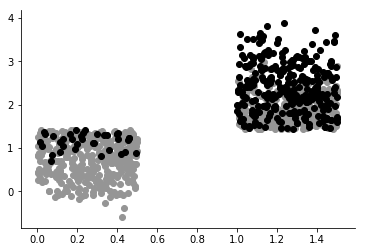

In [644]:
for i, g in df.groupby('inferred_cluster'):
    for c, gc in g.groupby('cluster'):
        noise = np.random.rand(gc.shape[0]) * 0.5
        plt.scatter(i + gc.y * 0 + noise , gc.y, c=cm.Greys(c / 2 + 1 / 2))

In [650]:
df.head()

,batch,cluster,depth,noise,y,inferred_cluster
0,1,1,0.369236,-0.309137,2.161188,1
1,0,0,0.422379,-0.506229,0.718201,0
2,1,0,0.384382,-0.639732,1.108831,0
3,1,1,0.512384,-0.012628,2.521612,1
4,1,0,0.413098,-2.631005,0.668444,0


\\[
y \vert (z_i = k) \sim \mathcal{N}(\mu_k + \alpha \cdot x_\text{depth} + \beta_j \cdot x_{\text{batch} = j}, \sigma_k)
\\]

In [608]:
X = patsy.dmatrix('~ C(batch) + depth', df, return_type='dataframe')
XX = X.values

K = 10
P = X.shape[1]

In [686]:
XX.shape

(1000, 3)

In [687]:
(np.dot(XX, np.ones((P, 1))) + np.ones((1, K))).shape

(1000, 2)

In [688]:
K = 2
P = X.shape[1]
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1., shape=(K,))
    alpha = pm.Normal('alpha', mu=0., sd=1., testval=1., shape=(P, 1))
    mu_cluster = pm.Normal('mu_cluster', mu=0., sd=1., testval=1., shape=(1, K))
    pi = pm.Dirichlet('pi', a=0.1 * np.ones(K), shape=(K,))

    mu = pm.math.dot(XX, alpha) + mu_cluster
    likelihood = pm.NormalMixture('y', w=pi, mu=mu, sd=sigma, observed=df['y'])

In [689]:
means, sds, elbos = pm.variational.advi(model=model, n=1000, learning_rate=1e-1)

Average ELBO = -1,291.5: 100%|███████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2147.61it/s]
Finished [100%]: Average ELBO = -1,290.9


In [690]:
means

{'alpha': array([[ 0.06706388],
        [ 0.51137022],
        [ 2.03863715]]),
 'mu_cluster': array([[ 0.87454467, -0.11863096]]),
 'pi_stickbreaking_': array([-0.6993302]),
 'sigma_log_': array([-1.35343494, -1.37067626])}

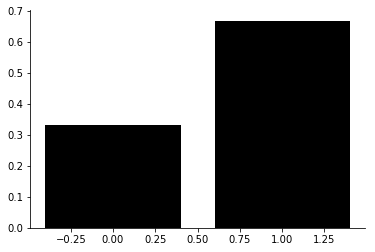

In [691]:
weights = pm.distributions.transforms.stick_breaking.backward(means['pi_stickbreaking_']).eval()
plt.bar(np.arange(K), weights, color='k');

In [692]:
inferred_cluster = []
for y, xx in zip(df.y[:, None], XX):
    mu = xx.dot(means['alpha'])
    RV = stats.norm(loc=mu + means['mu_cluster'], scale=np.exp(means['sigma_log_']))
    inferred_cluster.append(RV.logpdf(y).argmax())

In [693]:
df['inferred_cluster'] = inferred_cluster

In [694]:
pd.crosstab(df.cluster, df.inferred_cluster)

inferred_cluster,0,1
cluster,,
0,21,656
1,317,6


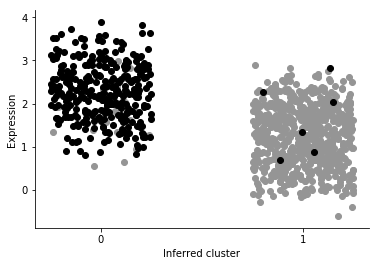

In [714]:
for i, g in df.groupby('inferred_cluster'):
    for c, gc in g.groupby('cluster'):
        noise = np.random.rand(gc.shape[0]) * 0.5
        plt.scatter(i + gc.y * 0 + noise , gc.y, c=cm.Greys(c / 2 + 1 / 2), label='Ground Truth: {}'.format(c))

plt.xticks([0.25, 1.25], [0, 1]);
plt.xlabel('Inferred cluster')
plt.ylabel('Expression');

\\[
y_g \vert (z_i = k) \sim \mathcal{N}(\mu_{g,k} + \alpha_g \cdot x_\text{depth} + \beta_{g, j} \cdot x_{\text{batch} = j}, \sigma_{g, k})
\\]

In [720]:
noise2 = np.random.normal(size=(1000, 1))
df['noise2'] = noise2
df['y2'] = 1. + 1.2 * df['cluster'] + df['batch'] * 0.5 + df['depth'] * 1.8 + df['noise2'] * 0.25

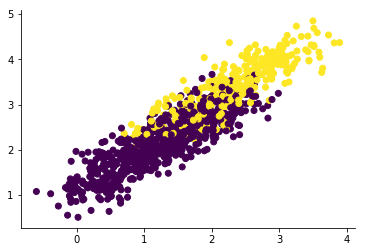

In [726]:
plt.scatter(df['y'], df['y2'], c=df.cluster);

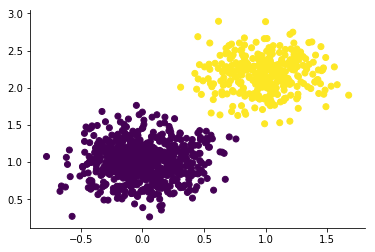

In [727]:
plt.scatter(df['y'] - df.depth * 2. - df.batch * 0.5, df['y2'] - df.depth * 1.8 - df.batch * 0.5, c=df.cluster);

In [731]:
from pymc3.math import logsumexp

In [732]:
# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

In [734]:
# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau, n_samples):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

In [800]:
G = 2
K = 2
with pm.Model() as model:
    mus = [pm.MvNormal('mu_%d' % i, mu=np.zeros(2), tau=0.1 * np.eye(G), shape=(G,)) for i in range(K)]
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    alpha = pm.Normal('alpha', mu=0., sd=1., testval=1., shape=(P, G))
    pi = pm.Dirichlet('pi', a=0.1 * np.ones(K), shape=(K,))
    
    mu_tech = [pm.math.dot(X, alpha) + mu for mu in mus]
    yg = pm.DensityDist('Y', logp_gmix(mu_tech, pi, sigma * np.eye(K), df.shape[0]), observed=df[['y', 'y2']])

In [805]:
means, sds, elbos = pm.variational.advi(model=model, n=1000, learning_rate=1e-1)

Average ELBO = -786.76: 100%|████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1328.57it/s]
Finished [100%]: Average ELBO = -789.26


In [806]:
means

{'alpha': array([[ 0.63935756,  1.25256157],
        [ 0.48901349,  0.48521498],
        [ 2.03951192,  1.8011695 ]]),
 'mu_0': array([-0.69458221, -0.24840747]),
 'mu_1': array([ 0.29980015,  0.94996631]),
 'pi_stickbreaking_': array([ 0.78966357]),
 'sigma_log_': array(2.7837811858747386)}

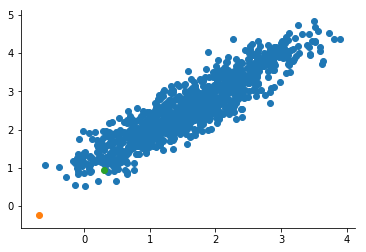

In [807]:
plt.scatter(df.y, df.y2)
plt.scatter(*means['mu_0'])
plt.scatter(*means['mu_1'])

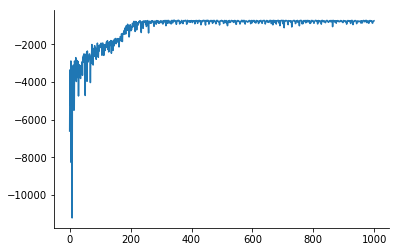

In [808]:
plt.plot(elbos);

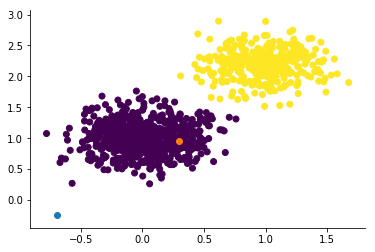

In [816]:
plt.scatter(df['y'] - df.depth * 2. - df.batch * 0.5, df['y2'] - df.depth * 1.8 - df.batch * 0.5, c=df.cluster);
plt.scatter(*means['mu_0'])
plt.scatter(*means['mu_1']);

In [730]:
K = 2
P = X.shape[1]
G = 2
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1., shape=(G, K))
    alpha = pm.Normal('alpha', mu=0., sd=1., testval=1., shape=(P, G))
    mu_cluster = pm.Normal('mu_cluster', mu=0., sd=1., testval=1., shape=(G, K))
    pi = pm.Dirichlet('pi', a=0.1 * np.ones(K), shape=(K,))

    mu = pm.math.dot(XX, alpha) + mu_cluster
    likelihood = pm.NormalMixture('y', w=pi, mu=mu, sd=sigma, observed=df[['y', 'y2']])

ValueError: Input dimension mis-match. (input[0].shape[0] = 1000, input[1].shape[0] = 2)

\\[
\mathbf{y}_i \vert (z_i = k) \sim \mathcal{N}(\alpha_i \cdot \mathbf{\mu}_k, \beta_i \cdot \Sigma_k)
\\]

\\[
\begin{align}
y_{g, j} | (z_j = k) &\sim \mathcal{N}(X \cdot \alpha_{g, k}, \sigma^2_{g, k} )
\end{align}
\\]

In [86]:
import patsy

In [107]:
X = patsy.dmatrix('np.log(total_counts) + 1', sample_info, return_type='dataframe')

Y = np.log1p(counts.sample(10, axis=0).T)

K = 3
G = Y.shape[1]
P = X.shape[1]

In [ ]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0., sd=1., testval=1., shape=(G, K, P))

In [118]:
alpha = np.ones((P, G, K))

In [122]:
a_0 = alpha[:, :, 0]

In [132]:
X.dot(a_0).shape

(144, 10)

In [130]:
Y.shape

(144, 10)